In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import graph_tool.all as gt

from pyvis.network import Network
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import display
from IPython.display import IFrame

In [2]:
sns.set()

## Data Preparation

In [3]:
from scipy.io import loadmat

In [4]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/ConnMatrixPre_cleaned.mat"
connmat = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/AllCells_cleaned.mat"
cellid = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/cellIDs.mat"
celltypes = loadmat(data_path) 

In [5]:
connmat = connmat["ConnMatrixPre_cleaned"]
cellid = cellid['AllCells_cleaned']
typenames = celltypes['cellIDs'].dtype
celltypes = celltypes['cellIDs'][0,0]

In [6]:
## graph construction

g = gt.Graph()
idx = connmat.T.nonzero()
g.add_edge_list(np.transpose(idx))

ew = g.new_edge_property("int32_t")
ew.a = connmat.T[idx] 
g.ep['#synapses'] = ew

vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    vw[v] = cellid[i]
g.vp['cellid'] = vw

## Neuron Types

In [7]:
neuron_type = []
for cid in cellid.T[0]:
    labelled = False
    # 16 different neuron types
    for i in range(16):
        if cid in celltypes[i][0]:
            neuron_type.append(i)
            labelled = True
            break
    if not labelled:
        # -1 indicates no type has been assigned
        neuron_type.append(-1)

In [8]:
vw = g.new_vertex_property("int32_t")
for i, v in enumerate(g.vertices()):
    vw[v] = neuron_type[i]
g.vp['celltype'] = vw

In [9]:
vw = g.new_vertex_property("bool")
for i, v in enumerate(g.vertices()):
    vw[v] = neuron_type[i] > -1
g.vp['cellselected'] = vw

## Preprocess - Remove Isolated Neurons 

In [10]:
print(g)
print("-----------------------")
print("max out-degree is {} and in-degree is {}".format(
    max(g.degree_property_map("out")),
    max(g.degree_property_map("in"))))
print("-----------------------")
print("max out-degree is {} and in-degree is {}".format(
    min(g.degree_property_map("out")),
    min(g.degree_property_map("in"))))

<Graph object, directed, with 2883 vertices and 44969 edges, 3 internal vertex properties, 1 internal edge property, at 0x7f08a44d7c50>
-----------------------
max out-degree is 165 and in-degree is 417
-----------------------
max out-degree is 0 and in-degree is 0


In [11]:
zero_deg_nodes = []
for v in g.vertices():
    if v.in_degree() == 0 and v.out_degree() == 0:
        zero_deg_nodes.append(v)
print("There are {} isolated neurons (indegree and outdegree are 0)".format(
    len(zero_deg_nodes)))

There are 59 isolated neurons (indegree and outdegree are 0)


In [12]:
false_annotation_nodes = []
for v in g.vertices():
    if g.vp['celltype'][v] == 14 or g.vp['celltype'][v] == 15:
        if v.out_degree() > 0:
            false_annotation_nodes.append(v)
print("There are {} abducens neurons have non-zero outdegree".format(
    len(false_annotation_nodes)))

There are 4 abducens neurons have non-zero outdegree


In [13]:
for v in reversed(sorted(zero_deg_nodes+false_annotation_nodes)):
    g.remove_vertex(v)

## Preprocess - Extract Connected Components

In [14]:
g_wcp, wcp_hist = gt.label_components(g, directed= False)

[   1    2 2817]


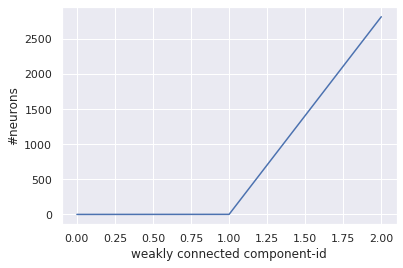

In [15]:
print(np.sort(wcp_hist))
plt.plot(np.sort(wcp_hist))
plt.xlabel("weakly connected component-id")
plt.ylabel("#neurons")
plt.show()

In [16]:
print("the largest weakly connected componed contains {} neurons".format(wcp_hist.max()))

the largest weakly connected componed contains 2817 neurons


In [17]:
g_scp, scp_hist = gt.label_components(g, directed = True)

[  1   1   1 ...   1   1 540]


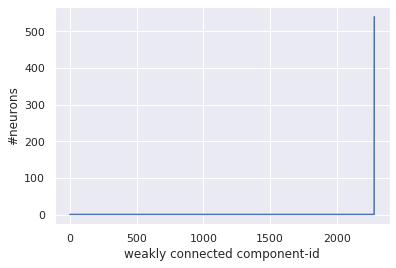

In [18]:
print(np.sort(scp_hist))
plt.plot(np.sort(scp_hist))
plt.xlabel("weakly connected component-id")
plt.ylabel("#neurons")
plt.show()

In [19]:
print("the largest strongly connected componed contains {} neurons".format(scp_hist.max()))

the largest strongly connected componed contains 540 neurons


In [20]:
# extract the largest weakly connnected subgraph
u = gt.extract_largest_component(g, directed=False)
print(u)

<GraphView object, directed, with 2817 vertices and 44311 edges, 3 internal vertex properties, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f08a3732780, at 0x7f08a3732eb8>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f08a3732780, at 0x7f08a3732f98>, False), at 0x7f08a3732780>


In [21]:
# %%time
# pos = gt.sfdp_layout(u)
# gt.graph_draw(u, pos=pos, inline=True)

In [22]:
# %%time
# # pos = gt.sfdp_layout(u)
# gt.graph_draw(u, pos=pos, vertex_fill_color=u.vp['celltype'], inline=True)

In [23]:
wcp_filter, _ = u.get_vertex_filter()

In [24]:
wcp_type_filter = g.new_vertex_property("bool")
for i, v in enumerate(g.vertices()):
    wcp_type_filter[v] = wcp_filter[v] & g.vp['cellselected'][v]

In [25]:
u.set_vertex_filter(wcp_type_filter)

In [26]:
_, temphist =  gt.label_components(u, directed=False)

In [27]:
np.sort(temphist)

array([  1,   1,   1,   1,   1,   1, 378], dtype=uint64)

In [28]:
# %%time
# pos = gt.sfdp_layout(u, gamma=10.0)
# gt.graph_draw(u, pos=pos, vertex_text=u.vp['celltype'], 
#               vertex_fill_color=u.vp['celltype'], inline=True)

In [29]:
u.set_vertex_filter(wcp_filter)

In [30]:
u = gt.Graph(u, prune=True)

In [31]:
wcp_type_filter = u.new_vertex_property("bool")
for i, v in enumerate(u.vertices()):
    wcp_type_filter[v] = u.vp['cellselected'][v]

In [32]:
print(u)

<Graph object, directed, with 2817 vertices and 44311 edges, 3 internal vertex properties, 1 internal edge property, at 0x7f08a376d748>


we only apply modularity analysis to these connected 2822 neurons.

##  Eigencentrality Subgraph
directly load from Louvain results.

In [33]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/MatOrder_CO_top500_2blocks_06122020.mat"
lou_cellid = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/cellIDType_CO_top500_2blocks_06122020.mat"
lou_celltypes = loadmat(data_path)

lou_cellid = lou_cellid['MatOrder_CO_top500_2blocks_06122020'].T
lou_celltypes = lou_celltypes['cellIDType_CO_top500_2blocks_06122020']

In [34]:
eigenmask = np.isin(lou_celltypes, ['_Axl_', '_DOs_', '_Int_'])
eigencenter = lou_cellid[eigenmask]

In [35]:
center_filter = u.new_vertex_property("bool")
for v in u.vertices():
    center_filter[v] = u.vp["cellid"][v] in eigencenter

In [36]:
(center_filter.a).sum()

PropertyArray(540, dtype=uint64)

In [37]:
center_type_filter = u.new_vertex_property("bool")
for i, v in enumerate(u.vertices()):
    center_type_filter[v] = u.vp['cellselected'][v] and center_filter[v]

In [38]:
u.set_vertex_filter(center_filter)

In [39]:
u

<Graph object, directed, with 540 vertices and 7132 edges, 3 internal vertex properties, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a3760e80>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a3760a90>, False), at 0x7f08a376d748>

## Algorithm1 - Nested Stochastic Block Models

In [40]:
# %%time
# # nSBM = gt.minimize_nested_blockmodel_dl(u, layers=True, state_args=dict(ec=u.ep["#synapses"], layers=True))
# # nSBM = gt.minimize_nested_blockmodel_dl(u, deg_corr=True)
# # nSBM = gt.minimize_nested_blockmodel_dl(u, deg_corr=False)
SBM = gt.minimize_blockmodel_dl(u, deg_corr=True, 
                                B_min=2, B_max=2,
                                state_args=dict(recs=[u.ep["#synapses"]], 
                                                   rec_types=["discrete-poisson"]))

In [41]:
u

<Graph object, directed, with 540 vertices and 7132 edges, 3 internal vertex properties, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a3760e80>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a3760a90>, False), at 0x7f08a376d748>

In [42]:
(SBM.get_blocks().a==1).sum()

PropertyArray(234)

In [43]:
print("Discription Length: ", SBM.entropy())

Discription Length:  39515.08990796963


In [44]:
import pickle
with open('saved/SBM_Zfish_eig.data', 'wb') as output:
    pickle.dump(SBM, output, pickle.HIGHEST_PROTOCOL)

with open('saved/SBM_Zfish_eig_u.data', 'wb') as output:
    pickle.dump(u, output, pickle.HIGHEST_PROTOCOL)

# with open('saved/SBM_Zfish_eig.data', 'rb') as input:    
#     nSBM = pickle.load(input)

# with open('saved/SBM_Zfish_eig_u.data', 'rb') as input:    
#     u = pickle.load(input)

In [45]:
u.vp["SBM"] = SBM.get_blocks()

In [46]:
u.set_vertex_filter(center_type_filter)

In [47]:
u

<Graph object, directed, with 194 vertices and 1820 edges, 4 internal vertex properties, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a3760e80>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f08a376d748, at 0x7f08a380d1d0>, False), at 0x7f08a376d748>

In [48]:
u_adj = gt.adjacency(u, weight=u.ep["#synapses"])

In [49]:
center_filter_mask = np.array(center_filter.a, dtype=bool) 

In [50]:
center_type_filter_mask = np.array(center_type_filter.a, dtype=bool)

In [51]:
dic_SBM2Type = np.array([u.vp["SBM"].a[center_type_filter_mask].tolist(), u.vp["celltype"].a[center_type_filter_mask].tolist()]).T

In [52]:
typenames = ['Saccadic_M', 'Saccadic_I', 'IBN', 'IBNmirrorPop', 'RS', 'Vestibular_DO', 'Vestibular_MO', 'Vestibular_TO', 'Integrator_r456I', 'Integrator_r456M', 'Integrator_r456MI', 'Integrator_r56M', 'Integrator_r78ipis', 'Integrator_r78contra', 'Abducens_M', 'Abducens_I']

In [53]:
typeM = np.zeros((2, 16))
for i in range(2):
    print("---")
    print("SBM type: {}".format(i))
    ids, cnts = np.unique(dic_SBM2Type[dic_SBM2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
        print(str(cnt)+" x "+str(name))

---
SBM type: 0
2 x IBN
34 x Vestibular_DO
48 x Integrator_r456I
15 x Integrator_r456M
34 x Integrator_r456MI
9 x Integrator_r56M
38 x Integrator_r78ipis
---
SBM type: 1
9 x RS
3 x Integrator_r456M
1 x Integrator_r456MI
1 x Integrator_r78ipis


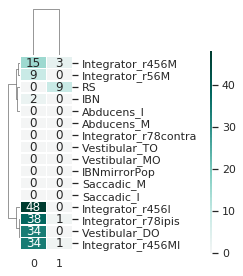

In [54]:
# plt.axis('off')
type_grid = sns.clustermap(typeM.T, 
               center=0, 
            xticklabels=np.arange(2),
            yticklabels=typenames,
            figsize=(3,4),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
# plt.xlabel("nSBM Level 0 Labels")
plt.show()

In [55]:
sepline = lambda x: np.cumsum(np.unique(x, return_counts=True)[1])

In [56]:
def pretty_print_label(labels):
    lbs = labels.copy().tolist()
    prev = -1
    start_i = 0
    for i, a in enumerate(lbs):
        if manual_group[a] == manual_group[prev]:
            lbs[i] = ""
        elif i == 0:
            lbs[i] = ""
            prev = a
            start_i = i
        else:
            pos = (start_i + i) // 2
            lbs[i] = ""
            lbs[pos] = manual_group[prev]
            prev = a
            start_i = i
    pos = (start_i + i) // 2
    lbs[pos] = manual_group[prev]
    return lbs

In [57]:
u.clear_filters()

In [58]:
abd_filter_mask = np.array(u.vp["celltype"].a)>=14

In [59]:
center_filter_mask = np.array(center_filter.a, dtype=bool) 

In [60]:
center_filter_mask.sum()

540

In [61]:
vw = u.new_vertex_property("int32_t")
for i, v in enumerate(u.vertices()):
    if u.vp["celltype"][v] >= 14:
        vw[v] = 2
    elif  u.vp["cellid"][v] in [76202,77267,77268,76562,77931]:
        vw[v] = 3
    else:
        vw[v] = u.vp["SBM"][v]
u.vp['SBM+ABD+vSPNs'] = vw

In [62]:
spn_filter_mask = np.isin(np.array(u.vp["cellid"].a), [76202,77267,77268,76562,77931])

In [63]:
plot_filter_mask = abd_filter_mask + center_filter_mask + spn_filter_mask

In [64]:
plot_filter_mask.sum()

595

In [65]:
manual_group = ["0", "1", "ABD", "vSPNs"]
uol = u.vp["SBM+ABD+vSPNs"].a[plot_filter_mask]
celltype_SBM = [""]*len(uol)
for i, v in enumerate(uol):
    celltype_SBM[i] = manual_group[v]

In [66]:
degree_seq = u.get_in_degrees(u.get_vertices())*u.get_out_degrees(u.get_vertices())
degree_seq = degree_seq[plot_filter_mask]

In [67]:
# ind_nSBML3_type = np.argsort(celltype_nSBM_L2)
ind_SBM_type = np.lexsort((degree_seq, celltype_SBM))

In [68]:
sep_SBM_type = sepline(celltype_SBM)

In [69]:
u_adj_full = gt.adjacency(u, weight=u.ep["#synapses"])

In [70]:
u_adj_sub = u_adj_full[plot_filter_mask][:, plot_filter_mask]

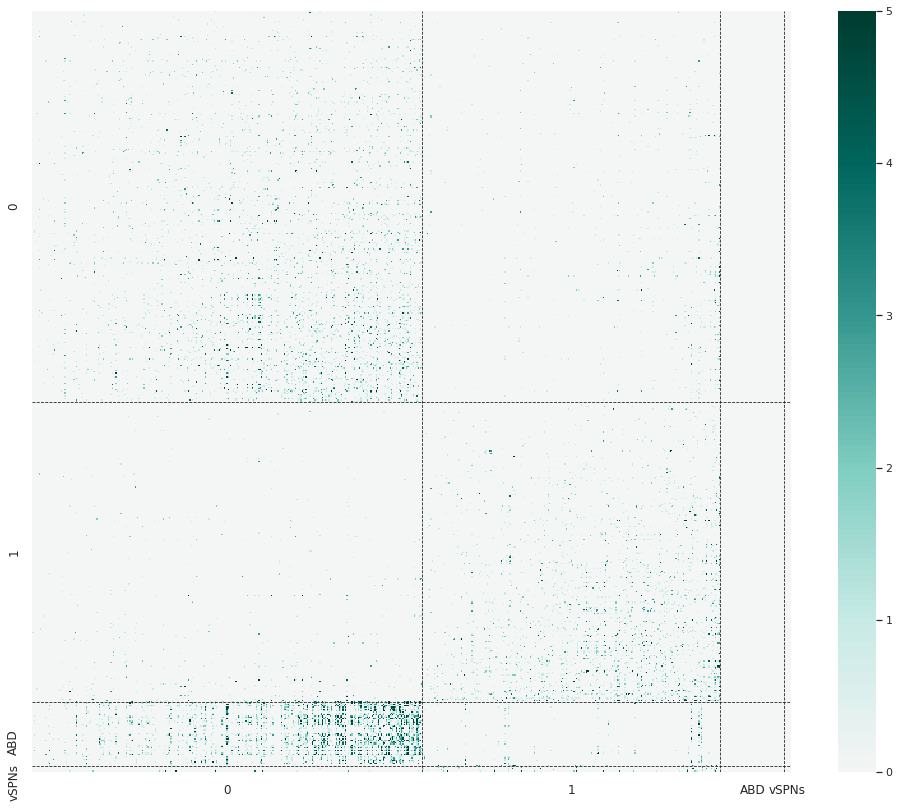

In [71]:
fig, ax = plt.subplots(figsize=(17,14))
# plt.axis('off')
sns.heatmap(np.minimum(u_adj_sub.todense()[ind_SBM_type][:,ind_SBM_type],5), 
            xticklabels=pretty_print_label(u.vp["SBM+ABD+vSPNs"].a[plot_filter_mask][ind_SBM_type]),
            yticklabels=pretty_print_label(u.vp["SBM+ABD+vSPNs"].a[plot_filter_mask][ind_SBM_type]),
            cmap="BrBG", center=0, ax=ax)
ax.hlines(sep_SBM_type, *ax.get_xlim(), linestyles='dashed', linewidths=0.8)
ax.vlines(sep_SBM_type, *ax.get_ylim(), linestyles='dashed', linewidths=0.8)

ax.tick_params(length=8, width=1.5, labelsize=12)

plt.show()

In [72]:
sep_SBM_type

array([306, 540, 590, 595])

In [73]:
def norm_conn(mat, col, row):
    res = np.zeros((len(row), len(col)))
    for i, c in enumerate(col):
        for j, r in enumerate(row):
            c_prev = 0 if i == 0 else col[i-1]
            r_prev = 0 if j == 0 else row[j-1]
            c_num = c - c_prev
            r_num = r - r_prev
            res[j, i] = mat[r_prev:r][:,c_prev:c].sum() / np.sqrt(c_num * r_num)
    return res

In [74]:
norm_conn(u_adj_sub.todense()[ind_SBM_type][:,ind_SBM_type], 
          sep_SBM_type[:2], sep_SBM_type)

array([[19.98366013,  3.02702757],
       [ 2.24597972, 17.33760684],
       [51.19118592,  2.88444102],
       [ 1.17601298,  7.57193423]])

In [75]:
with open('saved/finalgraph_SBM_Zfish_eig.data', 'wb') as output:
    pickle.dump(u, output, pickle.HIGHEST_PROTOCOL)

## Further partition the oculomotor module

In [76]:
om_mask = (np.array(u.vp['SBM'].a==0, dtype=bool) & center_filter_mask)

om_filter = u.new_vertex_property("bool")
for i, v in enumerate(u.vertices()):
    om_filter[v] = om_mask[i]

u.set_vertex_filter(om_filter)

In [77]:
om_SBM = gt.minimize_blockmodel_dl(u, deg_corr=True, 
                                B_min=2, B_max=2,
                                state_args=dict(recs=[u.ep["#synapses"]], 
                                                   rec_types=["discrete-poisson"]))

In [78]:
import pickle
with open('saved/SBM_omZfish_eig.data', 'wb') as output:
    pickle.dump(om_SBM, output, pickle.HIGHEST_PROTOCOL)

with open('saved/SBM_omZfish_eig_u.data', 'wb') as output:
    pickle.dump(u, output, pickle.HIGHEST_PROTOCOL)

# with open('saved/SBM_omZfish_eig.data', 'rb') as input:    
#     om_nSBM = pickle.load(input)

# with open('saved/SBM_omZfish_eig_u.data', 'rb') as input:    
#     u = pickle.load(input)

In [79]:
u.vp["om_SBM"] = om_SBM.get_blocks()

In [80]:
sub_center_type_filter_mask = om_mask & center_type_filter_mask

In [81]:
dic_omSBM2Type = np.array([u.vp["om_SBM"].a[sub_center_type_filter_mask].tolist(), u.vp["celltype"].a[sub_center_type_filter_mask].tolist()]).T

In [82]:
typenames = ['Saccadic_M', 'Saccadic_I', 'IBN', 'IBNmirrorPop', 'RS', 'Vestibular_DO', 'Vestibular_MO', 'Vestibular_TO', 'Integrator_r456I', 'Integrator_r456M', 'Integrator_r456MI', 'Integrator_r56M', 'Integrator_r78ipis', 'Integrator_r78contra', 'Abducens_M', 'Abducens_I']

In [83]:
typeM = np.zeros((2, 16))
for i in range(2):
    print("---")
    print("SBM type: {}".format(i))
    ids, cnts = np.unique(dic_omSBM2Type[dic_omSBM2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
        print(str(cnt)+" x "+str(name))

---
SBM type: 0
1 x IBN
2 x Vestibular_DO
47 x Integrator_r456I
11 x Integrator_r456MI
23 x Integrator_r78ipis
---
SBM type: 1
1 x IBN
32 x Vestibular_DO
1 x Integrator_r456I
15 x Integrator_r456M
23 x Integrator_r456MI
9 x Integrator_r56M
15 x Integrator_r78ipis


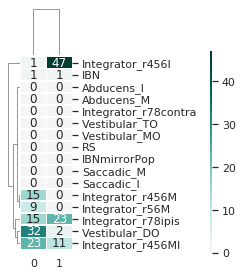

In [122]:
# plt.axis('off')
type_grid = sns.clustermap(typeM.T[:,::-1], 
               center=0, 
            xticklabels=np.arange(2),
            yticklabels=typenames,
            figsize=(3,4),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
# plt.xlabel("nSBM Level 0 Labels")
plt.show()

In [85]:
u.clear_filters()

In [86]:
vw = u.new_vertex_property("int32_t")
for i, v in enumerate(u.vertices()):
    if u.vp["celltype"][v] == 14:
        vw[v] = 2
    elif  u.vp["celltype"][v] == 15:
        vw[v] = 3
    else:
        vw[v] = u.vp["om_SBM"][v]
u.vp['omSBM+ABD_M+ABD_I'] = vw

In [87]:
center_filter_mask = np.array(center_filter.a, dtype=bool) 
plot_filter_mask = abd_filter_mask + (center_filter_mask & om_mask)

In [88]:
plot_filter_mask.sum()

356

In [101]:
manual_group = ["1", "0", "ABD_M", "ABD_I"]

uol = u.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask]
celltype_SBM = [""]*len(uol)
for i, v in enumerate(uol):
    celltype_SBM[i] = manual_group[v]

In [102]:
len(u.get_vertices())

2817

In [103]:
degree_seq = u.get_in_degrees(u.get_vertices())*u.get_out_degrees(u.get_vertices())
degree_seq = degree_seq[plot_filter_mask]

In [104]:
# ind_nSBML3_type = np.argsort(celltype_nSBM_L2)
ind_SBM_type = np.lexsort((degree_seq, celltype_SBM))

In [105]:
sep_SBM_type = sepline(celltype_SBM)

In [106]:
u_adj_full = gt.adjacency(u, weight=u.ep["#synapses"])

In [107]:
u_adj_sub = u_adj_full[plot_filter_mask][:, plot_filter_mask]

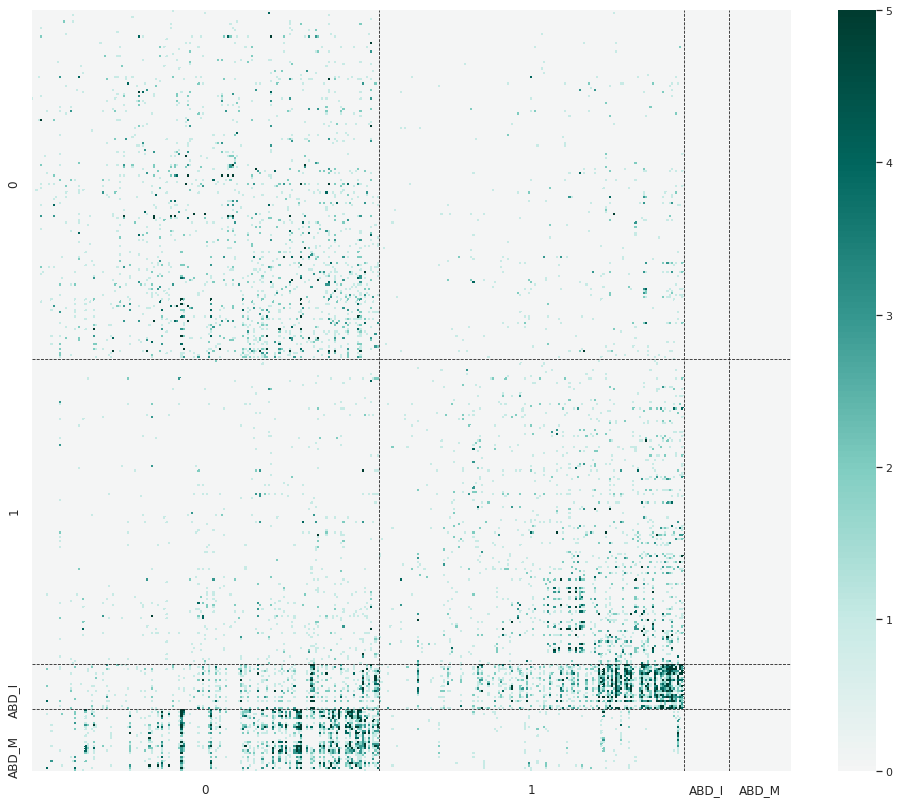

In [108]:
fig, ax = plt.subplots(figsize=(17,14))
# plt.axis('off')
sns.heatmap(np.minimum(u_adj_sub.todense()[ind_SBM_type][:,ind_SBM_type],5), 
            xticklabels=pretty_print_label(u.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask][ind_SBM_type]),
            yticklabels=pretty_print_label(u.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask][ind_SBM_type]),
            cmap="BrBG", center=0, ax=ax)
ax.hlines(sep_SBM_type, *ax.get_xlim(), linestyles='dashed', linewidths=0.8)
ax.vlines(sep_SBM_type, *ax.get_ylim(), linestyles='dashed', linewidths=0.8)

ax.tick_params(length=8, width=1.5, labelsize=12)

plt.show()

In [109]:
sep_SBM_type

array([163, 306, 327, 356])

In [110]:
def norm_conn(mat, col, row):
    res = np.zeros((len(row), len(col)))
    for i, c in enumerate(col):
        for j, r in enumerate(row):
            c_prev = 0 if i == 0 else col[i-1]
            r_prev = 0 if j == 0 else row[j-1]
            c_num = c - c_prev
            r_num = r - r_prev
            res[j, i] = mat[r_prev:r][:,c_prev:c].sum() / np.sqrt(c_num * r_num)
    return res

In [111]:
norm_conn(u_adj_sub.todense()[ind_SBM_type][:,ind_SBM_type], 
          sep_SBM_type[:2], sep_SBM_type)

array([[16.92638037,  2.84267957],
       [ 4.30331908, 15.83916084],
       [14.83598124, 48.08426184],
       [38.32549903,  3.01255311]])

In [112]:
with open('saved/finalgraph_SBM_omZfish_eig.data', 'wb') as output:
    pickle.dump(u, output, pickle.HIGHEST_PROTOCOL)